In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import matplotlib.ticker as ticker
import numpy as np
import datetime

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
# imports
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_selector
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_union
from sklearn.compose import make_column_transformer
from sklearn import set_config
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, Lasso, LinearRegression

In [4]:
!ls drive/MyDrive/LeWagonProject

UPDATE_full_data_clean_inclCluster.csv


In [5]:
df = pd.read_csv('drive/MyDrive/LeWagonProject/UPDATE_full_data_clean_inclCluster.csv')

In [6]:
df.head()

,Unnamed: 0,Unnamed: 0.1,Store ID,Item ID,Store Category,Store Segment,Store Region,City,Store Address,Item First Supplying Date,...,Count Ratings,Declared Supply,Meals Saved,Total Supply,Avg Rating Overall,Pickup Length,Supply Length,Region Language,Region Type,Cluster
0,0,0,11344,11438,Key Account,Bakery,Genève,GenÃ¨ve,Place de Cornavin 7,2017-12-07 00:00:00,...,0,20,2,20,0.00,0 days 00:50:00,1545,french,urban,0
1,1,1,11729,11822,Indie - Outbound,Buffet,Bern,Bern,LÃ¤nggassstrasse 53,2018-11-02 00:00:00,...,1,0,9,16,4.00,0 days 04:00:00,237,german,urban,0
2,2,2,11729,11822,Indie - Outbound,Buffet,Bern,Bern,LÃ¤nggassstrasse 53,2018-11-02 00:00:00,...,8,0,28,33,4.25,0 days 04:00:00,237,german,urban,0
3,3,3,11729,11822,Indie - Outbound,Buffet,Bern,Bern,LÃ¤nggassstrasse 53,2018-11-02 00:00:00,...,0,10,11,17,0.00,0 days 04:00:00,237,german,urban,0
4,4,4,11729,11822,Indie - Outbound,Buffet,Bern,Bern,LÃ¤nggassstrasse 53,2018-11-02 00:00:00,...,1,10,13,17,5.00,0 days 04:00:00,237,german,urban,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2616743 entries, 0 to 2616742
Data columns (total 25 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   Unnamed: 0                     int64  
 1   Unnamed: 0.1                   int64  
 2   Store ID                       int64  
 3   Item ID                        int64  
 4   Store Category                 object 
 5   Store Segment                  object 
 6   Store Region                   object 
 7   City                           object 
 8   Store Address                  object 
 9   Item First Supplying Date      object 
 10  Item Last Supplying Date       object 
 11  Item Price                     float64
 12  Pickup Time Start Time of Day  object 
 13  Pickup Time End Time of Day    object 
 14  Date                           object 
 15  Count Ratings                  int64  
 16  Declared Supply                int64  
 17  Meals Saved                    int64  
 18  To

## Data Preprocessing

In [8]:
# Check for duplicates
df.duplicated().sum()

0

In [9]:
# Check for nan:
df.isnull().sum().sort_values(ascending=False)

Unnamed: 0                       0
Pickup Time End Time of Day      0
Region Type                      0
Region Language                  0
Supply Length                    0
Pickup Length                    0
Avg Rating Overall               0
Total Supply                     0
Meals Saved                      0
Declared Supply                  0
Count Ratings                    0
Date                             0
Pickup Time Start Time of Day    0
Unnamed: 0.1                     0
Item Price                       0
Item Last Supplying Date         0
Item First Supplying Date        0
Store Address                    0
City                             0
Store Region                     0
Store Segment                    0
Store Category                   0
Item ID                          0
Store ID                         0
Cluster                          0
dtype: int64

In [10]:
# Check for date columns to remove:
df[['Date','Item First Supplying Date','Item Last Supplying Date','Pickup Time Start Time of Day','Pickup Time End Time of Day']].head()

,Date,Item First Supplying Date,Item Last Supplying Date,Pickup Time Start Time of Day,Pickup Time End Time of Day
0,2019-01-01 00:00:00,2017-12-07 00:00:00,2022-03-01 00:00:00,1900-01-01 20:00:00,1900-01-01 20:50:00
1,2019-01-01 00:00:00,2018-11-02 00:00:00,2019-06-27 00:00:00,1900-01-01 18:30:00,1900-01-01 22:30:00
2,2019-01-02 00:00:00,2018-11-02 00:00:00,2019-06-27 00:00:00,1900-01-01 18:30:00,1900-01-01 22:30:00
3,2019-01-27 00:00:00,2018-11-02 00:00:00,2019-06-27 00:00:00,1900-01-01 18:30:00,1900-01-01 22:30:00
4,2019-01-31 00:00:00,2018-11-02 00:00:00,2019-06-27 00:00:00,1900-01-01 18:30:00,1900-01-01 22:30:00


### Add column to cluster Pickup start time

In [11]:
# Add column to cluster Pickup start time:
conditions = [
    (df['Pickup Time Start Time of Day'] <= "1900-01-01 11:59:00"),
    (df['Pickup Time Start Time of Day'] >= "1900-01-01 12:00:00") & (df['Pickup Time Start Time of Day'] < "1900-01-01 17:00:00"),
    (df['Pickup Time Start Time of Day'] >= "1900-01-01 17:00:00") & (df['Pickup Time Start Time of Day'] < "1900-01-01 21:00:00"),
    (df['Pickup Time Start Time of Day'] >= "1900-01-01 21:00:00")
    ]

values = ['morning', 'afternoon', 'early evening', 'late evening']

df['Pickp_time_of_day'] = np.select(conditions, values)

###  Convert Pickup Length

In [12]:
# Fuction to convert:
def pickup_conv(x):
    x=str(x)
    x=x[len(x)-8:len(x)]
    h,m,s = x.split(':')
    x=int((datetime.timedelta(hours=int(h),minutes=int(m),seconds=int(s)).total_seconds())/60)
    return x

In [13]:
#Converting the whole column
df['Pickup Length']=df['Pickup Length'].map(pickup_conv)

In [14]:
df.head(3)

,Unnamed: 0,Unnamed: 0.1,Store ID,Item ID,Store Category,Store Segment,Store Region,City,Store Address,Item First Supplying Date,...,Declared Supply,Meals Saved,Total Supply,Avg Rating Overall,Pickup Length,Supply Length,Region Language,Region Type,Cluster,Pickp_time_of_day
0,0,0,11344,11438,Key Account,Bakery,Genève,GenÃ¨ve,Place de Cornavin 7,2017-12-07 00:00:00,...,20,2,20,0.00,50,1545,french,urban,0,early evening
1,1,1,11729,11822,Indie - Outbound,Buffet,Bern,Bern,LÃ¤nggassstrasse 53,2018-11-02 00:00:00,...,0,9,16,4.00,240,237,german,urban,0,early evening
2,2,2,11729,11822,Indie - Outbound,Buffet,Bern,Bern,LÃ¤nggassstrasse 53,2018-11-02 00:00:00,...,0,28,33,4.25,240,237,german,urban,0,early evening


### Define X and y

In [15]:
# Remove columns: define X and y
X = df.drop(columns=['Total Supply','Unnamed: 0','Unnamed: 0.1','Store ID','Item ID','Date','Item First Supplying Date','Item Last Supplying Date','Pickup Time Start Time of Day','Pickup Time End Time of Day','City','Store Address'])
y = df['Total Supply']

In [16]:
X.head()

,Store Category,Store Segment,Store Region,Item Price,Count Ratings,Declared Supply,Meals Saved,Avg Rating Overall,Pickup Length,Supply Length,Region Language,Region Type,Cluster,Pickp_time_of_day
0,Key Account,Bakery,Genève,4.5,0,20,2,0.00,50,1545,french,urban,0,early evening
1,Indie - Outbound,Buffet,Bern,6.9,1,0,9,4.00,240,237,german,urban,0,early evening
2,Indie - Outbound,Buffet,Bern,6.9,8,0,28,4.25,240,237,german,urban,0,early evening
3,Indie - Outbound,Buffet,Bern,6.9,0,10,11,0.00,240,237,german,urban,0,early evening
4,Indie - Outbound,Buffet,Bern,6.9,1,10,13,5.00,240,237,german,urban,0,early evening


In [17]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2616743 entries, 0 to 2616742
Data columns (total 14 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Store Category      object 
 1   Store Segment       object 
 2   Store Region        object 
 3   Item Price          float64
 4   Count Ratings       int64  
 5   Declared Supply     int64  
 6   Meals Saved         int64  
 7   Avg Rating Overall  float64
 8   Pickup Length       int64  
 9   Supply Length       int64  
 10  Region Language     object 
 11  Region Type         object 
 12  Cluster             int64  
 13  Pickp_time_of_day   object 
dtypes: float64(2), int64(6), object(6)
memory usage: 279.5+ MB


In [18]:
X.describe()

,Item Price,Count Ratings,Declared Supply,Meals Saved,Avg Rating Overall,Pickup Length,Supply Length,Cluster
count,2.616743e+06,2.616743e+06,2.616743e+06,2.616743e+06,2.616743e+06,2.616743e+06,2.616743e+06,2.616743e+06
mean,6.572431e+00,6.495097e-01,2.236136e+00,1.752282e+00,2.003468e+00,4.856899e+01,7.092476e+02,1.599506e+00
std,2.704585e+00,9.427872e-01,2.092234e+00,2.099286e+00,2.300168e+00,7.977479e+01,3.384196e+02,1.155228e+00
min,1.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.900000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,3.000000e+01,4.700000e+02,1.000000e+00
50%,5.900000e+00,0.000000e+00,2.000000e+00,1.000000e+00,0.000000e+00,3.000000e+01,7.180000e+02,2.000000e+00
75%,6.900000e+00,1.000000e+00,3.000000e+00,2.000000e+00,5.000000e+00,3.000000e+01,9.850000e+02,3.000000e+00
max,9.490000e+01,9.400000e+01,9.990000e+02,8.000000e+02,5.000000e+00,1.410000e+03,1.550000e+03,3.000000e+00


# Model 1: y=Total Supply

In [19]:
# Split into Train/Test -> to do on all dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [21]:
num_transformer = make_pipeline(RobustScaler())    #### Removed Simple Imputer
cat_transformer = make_pipeline(OneHotEncoder(handle_unknown='ignore'))
preprocess = make_column_transformer((num_transformer, ['Item Price', 'Count Ratings', 'Declared Supply', 'Meals Saved', 'Avg Rating Overall','Pickup Length','Supply Length']),
                                     (cat_transformer,['Store Category', 'Store Segment', 'Store Region', 'Region Language', 'Region Type','Pickp_time_of_day','Cluster']))

In [22]:
# visualizing pipelines in HTML
set_config(display='diagram')
preprocess

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('robustscaler',
                                                  RobustScaler())]),
                                 ['Item Price', 'Count Ratings',
                                  'Declared Supply', 'Meals Saved',
                                  'Avg Rating Overall', 'Pickup Length',
                                  'Supply Length']),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Store Category', 'Store Segment',
                                  'Store Region', 'Region Language',
                                  'Region Type', 'Pickp_time_of_day',
                                  'Cluster'])])

In [23]:
X_train_transformed = preprocess.fit_transform(X_train)

In [24]:
display(pd.DataFrame(X_train_transformed.todense()).head(3))

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,72
0,-0.5,0.0,-0.5,0.0,0.0,0.0,-0.213592,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.5,0.0,0.5,0.0,0.0,0.0,-0.508738,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.5,0.0,0.0,0.0,0.0,0.0,0.056311,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


LINEAR REGRESSION

In [25]:
pipe = make_pipeline(preprocess, LinearRegression())
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('robustscaler',
                                                                   RobustScaler())]),
                                                  ['Item Price',
                                                   'Count Ratings',
                                                   'Declared Supply',
                                                   'Meals Saved',
                                                   'Avg Rating Overall',
                                                   'Pickup Length',
                                                   'Supply Length']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Store Category',
                                                   'Store Segment',
                                                   'Store Region',
                                                   'Region Language',
                                                   'Region Type',
                                                   'Pickp_time_of_day',
                                                   'Cluster'])])),
                ('linearregression', LinearRegression())])

In [26]:
# Train pipeline, # Make predictions, # Score model
pipe.fit(X_train,y_train)
pipe.predict(X_test)
pipe.score(X_test,y_test)

0.7381099818373424

In [45]:
pipe[-1].summary()

AttributeError: ignored

In [27]:
from sklearn.model_selection import cross_val_score

# Cross validate pipeline
cross_val_score(pipe, X_train, y_train, cv=5, scoring='r2').mean()

0.691884745880645

### RIDGE

In [44]:
# Add Estimator: model 1 - Linear Regression
pipe2 = make_pipeline(preprocess,Ridge())
pipe2

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('robustscaler',
                                                                   RobustScaler())]),
                                                  ['Item Price',
                                                   'Count Ratings',
                                                   'Declared Supply',
                                                   'Meals Saved',
                                                   'Avg Rating Overall',
                                                   'Pickup Length',
                                                   'Supply Length']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Store Category',
                                                   'Store Segment',
                                                   'Store Region',
                                                   'Region Language',
                                                   'Region Type',
                                                   'Pickp_time_of_day',
                                                   'Cluster'])])),
                ('ridge', Ridge())])

In [30]:
# Train pipeline
pipe2.fit(X_train,y_train)

# Make predictions
pipe2.predict(X_test)

# Score model
pipe2.score(X_test,y_test)

0.7372578041197699

In [33]:
# Cross validate pipeline
cross_val_score(pipe2, X_train, y_train, cv=5, scoring='r2').mean()

0.6910275307995479

In [49]:
pipe2[-1].coef_

AttributeError: ignored

### Lasso

In [31]:
pipe3 = make_pipeline(preprocess, Lasso())
pipe3

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('robustscaler',
                                                                   RobustScaler())]),
                                                  ['Item Price',
                                                   'Count Ratings',
                                                   'Declared Supply',
                                                   'Meals Saved',
                                                   'Avg Rating Overall',
                                                   'Pickup Length',
                                                   'Supply Length']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Store Category',
                                                   'Store Segment',
                                                   'Store Region',
                                                   'Region Language',
                                                   'Region Type',
                                                   'Pickp_time_of_day',
                                                   'Cluster'])])),
                ('lasso', Lasso())])

In [32]:
# Train pipeline
pipe3.fit(X_train,y_train)

# Make predictions
pipe3.predict(X_test)

# Score model
pipe3.score(X_test,y_test)

0.5238647876500141

In [54]:
pipe3[-1]

AttributeError: ignored

In [34]:
# Cross validate pipeline
cross_val_score(pipe3, X_train, y_train, cv=5, scoring='r2').mean()

0.4973290228098869

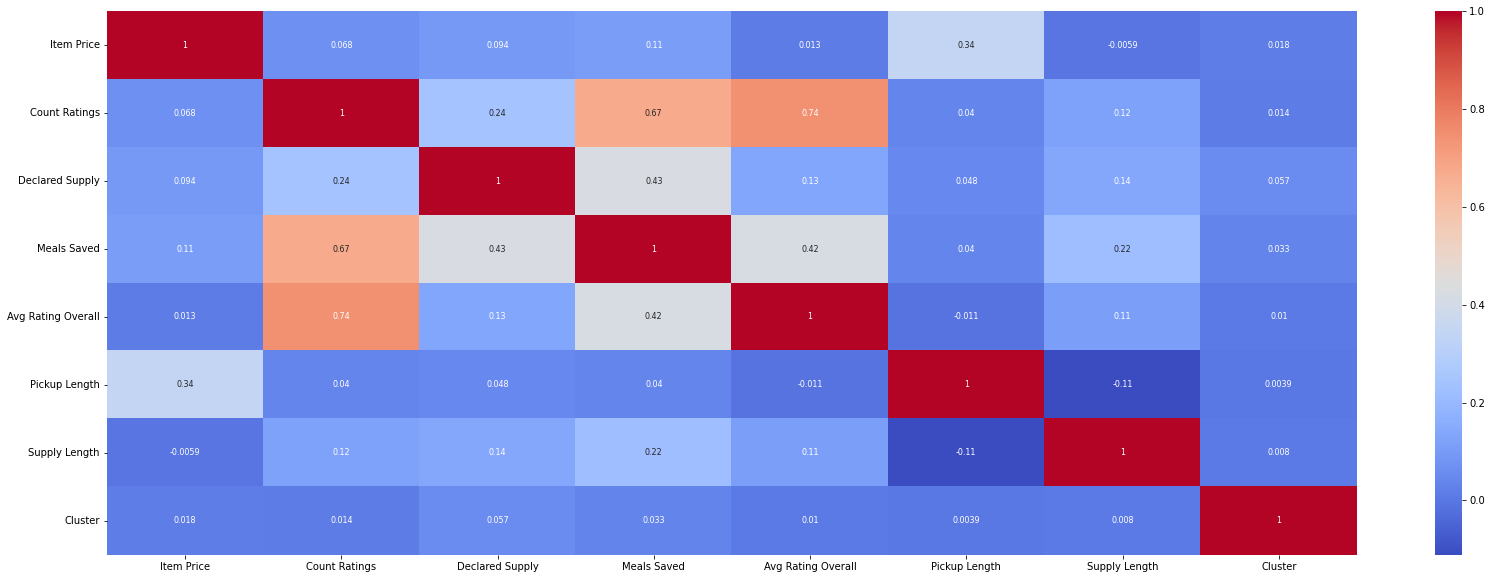

In [36]:
# Checking correlation between independent variables (features):
# Need to encode categorical variables
plt.figure(figsize=(28,10))
sns.heatmap(X_train.corr(),xticklabels=X_train.corr().columns, yticklabels=X_train.corr().columns, cmap='coolwarm', annot = True, annot_kws={"size": 8})

In [39]:
corr = X_train.corr()
corr_df = corr.unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df

,feature_1,feature_2,correlation
33,Avg Rating Overall,Count Ratings,0.744779
12,Count Ratings,Avg Rating Overall,0.744779
11,Count Ratings,Meals Saved,0.672548
25,Meals Saved,Count Ratings,0.672548
26,Meals Saved,Declared Supply,0.426287
19,Declared Supply,Meals Saved,0.426287
35,Avg Rating Overall,Meals Saved,0.421292
28,Meals Saved,Avg Rating Overall,0.421292
40,Pickup Length,Item Price,0.344712
5,Item Price,Pickup Length,0.344712
